## MeanFlow 
Kaiming He and others have released a paper on flow based model where they are modeling average velocity instead of instantaneous velocity as we have seen in the previous flow implementation.

In [1]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

## Foundations - Gradients
Paper speaks about Jacobian vector product, while I would like you to refer to some good resources on internet for what directional derivatives means because trust me they are easy to explain visually in a video than on a blog. I will still do my job here using a simple example, consider an example $f(x)=x^2y$

Now the partial derivate of this function basically gives

$$
\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
$$

$$
\nabla f = \begin{bmatrix} 2xy \\ x^2 \end{bmatrix}
$$

Now the gradient is like a vector field as shown below




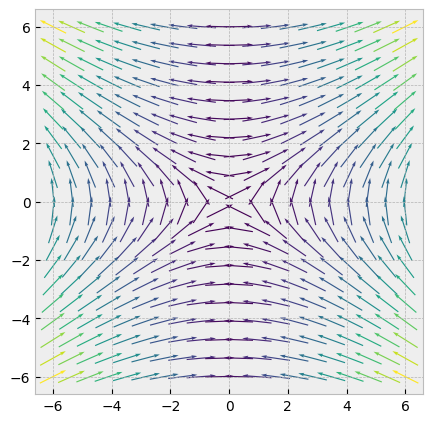

In [ ]:
x = np.linspace(-6, 6, 20)
y = np.linspace(-6, 6, 20)
X, Y = np.meshgrid(x, y)

# Calculate vector components
# f(x, y) = [2xy, x^2]
U = 2*X*Y  # x-component: 2xy
V = X**2  # y-component: x^2
magnitude = np.sqrt(U**2 + V**2)

U_norm = U/magnitude
V_norm = V/magnitude

# Create the plot
plt.figure(figsize=(5, 5))

# Plot the vector field with color based on magnitude
plt.quiver(X, Y, U_norm, V_norm, magnitude, cmap='viridis', 
           pivot='mid', angles='xy', scale_units='xy', scale=1)
plt.show()

## Foundations Directional derivatives 
A small nudge in x and in y basically gives the rate of change in the function f(x,y), this is often represented in partial derivatives as [$\frac{df}{dx}$, $\frac{df}{dy}$] (shown above). Now from any point on the function there can be several unit vectors pointing in different directions, lets call this vector $\vec{v}$ and represented as $[a, b]$. Now as we move along this vector direction, a small nudge in x direction means its equivalent to $a*\nabla x f$ and small nudge in y direction means its equivalent to $b*\nabla y f$


we can write this equation as 

$$
df = \frac{\partial f}{\partial x} dx + \frac{\partial f}{\partial y} dy
$$

the directional derivative is simply the dot product.
$$
D_{\vec{v}}f = \frac{df}{ds} = a \frac{\partial f}{\partial x} + b \frac{\partial f}{\partial y} = \nabla f \cdot \vec{v}
$$

Now lets calculate directional derivate of a function $f(x,y) = x^2y$ at (1,2) in the direction of (-1/$\sqrt{5}$, 2/$\sqrt{5}$)

$$
df = -1/\sqrt{5} * \frac{\partial f}{\partial x} + 2\sqrt{5} * \frac{\partial f}{\partial y}
$$

$$
\frac{\partial f}{\partial x} = 2xy = 2*1*2 = 4
$$

$$
\frac{\partial f}{\partial y} = x^2 = 1
$$

$$
df = \frac{-1}{\sqrt{5}} * 4 + \frac{2}{\sqrt{5}} * 1 = \frac{-2}{\sqrt{5}}
$$

In [3]:
-2/torch.sqrt(torch.tensor(5))

tensor(-0.8944)

## Jacobian vector product 
In pytorch calculating this directional derivative is called Jacobian vector product. we will do the above example using pytorch now.

In [4]:
point = torch.tensor([1.0, 2.0], requires_grad=True)
x, y = point[0], point[1]

# Define direction vector (not necessarily unit vector initially)
direction = torch.tensor([-1.0, 2.0])

# Normalize to make it a unit vector for proper directional derivative
unit_direction = direction / torch.norm(direction)
unit_direction


tensor([-0.4472,  0.8944])

In [5]:
def func_vector_input(inputs):
    x, y = inputs[0], inputs[1]
    return x**2 * y

In [6]:
func_output, directional_deriv_jvp = torch.autograd.functional.jvp(
    func_vector_input, 
    (point,), 
    (unit_direction,)
)
func_output, directional_deriv_jvp

(tensor(2.), tensor(-0.8944))

> the second term is the directional derivative of the function. 

> first term in the function output

we can see that both are same. we will now learn why this is important and how it is used in the paper.

## Paper 



## We will use CIFAR10 this time

In [7]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
def load_cifar10(bs=64):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('data/', train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])),
        batch_size=bs, shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('data/', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])),
        batch_size=bs, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = load_cifar10()

print(len(train_loader), len(val_loader))

imgs, labels = next(iter(train_loader))
imgs.shape

782 157


torch.Size([64, 3, 32, 32])

In [8]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

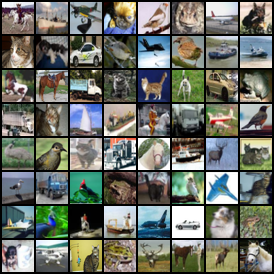

In [9]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8, normalize=True))

In [10]:
time = torch.distributions.Uniform(0, 1)
rt = time.sample((10,2)).sort(dim=1).values
rt

tensor([[0.1440, 0.3904],
        [0.7439, 0.7935],
        [0.2429, 0.3577],
        [0.1988, 0.7482],
        [0.4300, 0.6451],
        [0.7084, 0.7270],
        [0.4174, 0.4669],
        [0.4010, 0.7290],
        [0.4037, 0.6415],
        [0.3703, 0.6496]])

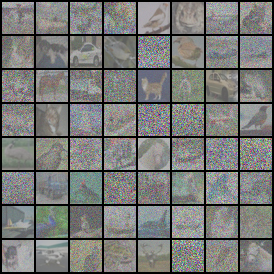

In [11]:
bs = imgs.shape[0]
rt = time.sample((bs,2)).sort(dim=1).values
noise = torch.randn_like(imgs)
t = rt[:, 1].unsqueeze(1).unsqueeze(1).unsqueeze(1)
xt = t*(imgs) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt, nrow=8, normalize=True))


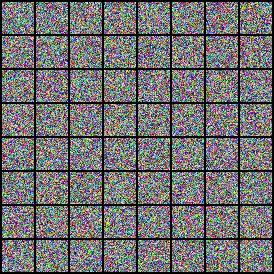

In [12]:
target = imgs - noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(target, nrow=8, normalize=False))

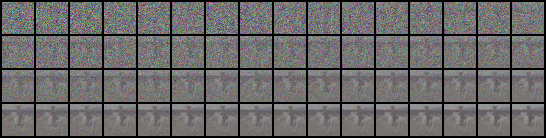

In [13]:
# lets also look how same image looks at different timesteps
simgs = imgs[0].unsqueeze(0).repeat(bs, 1, 1, 1)
bs = simgs.shape[0]
t = torch.linspace(0, 1, bs).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(simgs)
sxt = (t)*simgs + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(sxt, nrow=16, normalize=True))

## Network
we have two conditionals here r and t. in the paper they mentioned we can condition this as 
- r, t separately 
- t, t-r 
- t, r, t-r 
- t-r only 

> t, t-r got the best results. 


for imageNet they used DiT architecture but for CIFAR-10 they used U-Net. we cannot use U-Net from diffusers directly as it takes only one time conditioning and here we have to condition on two variables t and t-r. In the paper, they took positional embeddings of the time variables and then concatenated them before sending to the architecture. 

I have made these changes to diffusers UNet 2D using `multiple_time_embeddings`
- for both t and t-r get positional embeddings. 
- use linear layers to calculate their embeddings. 
- concat both of these.

In [14]:
from unet2d import UNet2DModel

device = "cuda"

model = UNet2DModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    multiple_time_embeddings=True,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
)
model.to(device)
print("model loaded")

/home/prakashjay/genai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model loaded


In [15]:
from diffusers.models.attention_processor import AttnProcessor


for blocks in model.down_blocks:
    if hasattr(blocks, "attentions"):
        for attn in blocks.attentions:
            attn.processor = AttnProcessor()

for blocks in model.up_blocks:
    if hasattr(blocks, "attentions"):
        for attn in blocks.attentions:
            attn.processor = AttnProcessor()

model.mid_block.attentions[0].processor = AttnProcessor()
print("processor set")

processor set


In [16]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


63425155

In [17]:
out = model(xt.to(device), (rt*1000).to(device))
out.shape, torch.nn.functional.mse_loss(out, target.to(device))

(torch.Size([64, 3, 32, 32]),
 tensor(1.4518, device='cuda:0', grad_fn=<MseLossBackward0>))

In [18]:
u, dudt = torch.autograd.functional.jvp(
    model, 
    (xt.to(device), (rt*1000).to(device)), 
    (target.to(device), torch.tensor([0, 1]).repeat(xt.shape[0], 1).to(device))
)
U.shape, dudt.shape

((20, 20), torch.Size([64, 3, 32, 32]))

In [19]:
u_tgt = target.to(device) - (rt[:, 1] - rt[:, 0]).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)*dudt
error = torch.nn.functional.mse_loss(u, u_tgt.detach())
error
# calculate the gradient of the error with respect to the model parameters

tensor(1.9009, device='cuda:0')

In [20]:
rt.shape, torch.tensor([[0.0, 1.0]]).shape

(torch.Size([64, 2]), torch.Size([1, 2]))

## One step sampling

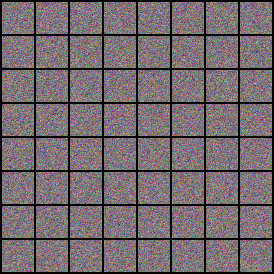

In [21]:
def one_step_sampling(model, bs, scale=1000):
    e = torch.randn(bs, 3, 32, 32).cuda()
    sample = model(e, torch.tensor([[0.0, 1.0*scale]]*bs).cuda())
    x = e - sample 
    return x 

x = one_step_sampling(model, 64)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True))

## Multistep sampling. 

In [22]:
r = torch.arange(0, 1000+(1000//200), 1000//200)
rt = torch.stack([r[:-1], r[1:]]).permute(1, 0)
rt.shape

torch.Size([200, 2])

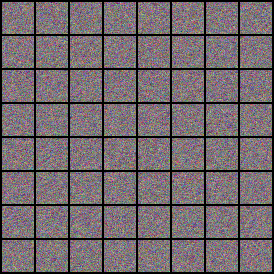

In [23]:
def multi_step_sampling(model, bs, n_steps, scale=1000):
    e = torch.randn(bs, 3, 32, 32).to(model.device)
    r = torch.arange(0, scale+(scale//n_steps), scale//n_steps).to(model.device)
    rt = torch.stack([r[:-1], r[1:]]).permute(1, 0)
    for i in range(n_steps):
        _rt = rt[i]
        r, t = _rt/scale 
        sample = model(e, torch.tensor([[r*scale, t*scale]]*bs).to(model.device))
        e = e - (t-r)*sample 
    return e 

x = multi_step_sampling(model, 64, 10)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.detach().cpu(), nrow=8, normalize=True))

## Full training pipeline 

In the paper they found the following parameters to work and gave the best FID score.
- 25% of the training loop r is not equal to t. this means that it drops down to simple Flow matching 
- t and r comes from lognorm(-0.4, 1.0). In paper this is little confusion to me whether it is logit norm or LogNorm. I will go with logitnorm. 
- used Pseudo-Huber loss and the got the best FID score for p=1.5 
- jvp used is (v, 0, 1).
- instead of (r, t), (t, t-r) gave the best results though the changes are minimal. so we will continue using (r, t)
- CFG scale: we will skip this for now. 

In [24]:
norm = torch.distributions.Normal(loc=-2, scale=2)
rt = torch.sigmoid(norm.sample((bs,2))).sort(dim=1).values 
rt.shape

torch.Size([64, 2])

In [25]:
def sample_rt(bs, dist, p=0.25):
    rt1 = torch.sigmoid(dist.sample((int(bs*p),2))).sort(dim=1).values
    rt2 = torch.sigmoid(dist.sample((int(bs*(1-p)), )))
    rt2 = torch.stack([rt2, rt2]).permute(1, 0)
    rt = torch.cat([rt1, rt2], dim=0)
    #shuffle rows 
    rt = rt[torch.randperm(rt.shape[0])]
    return rt 

In [26]:
sample_rt(16, norm, 0.25)

tensor([[0.0155, 0.0786],
        [0.0474, 0.1375],
        [0.0233, 0.0233],
        [0.0350, 0.0350],
        [0.0614, 0.0614],
        [0.6526, 0.6526],
        [0.0584, 0.1185],
        [0.6080, 0.6080],
        [0.1782, 0.1782],
        [0.1624, 0.1624],
        [0.7894, 0.7894],
        [0.0107, 0.0107],
        [0.0382, 0.0382],
        [0.0874, 0.4929],
        [0.0016, 0.0016],
        [0.6199, 0.6199]])

In [27]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.99995)
ema_model = copy.deepcopy(model)

In [28]:
import fastcore.all as fc 
storage_path = fc.Path("mean_flow")
storage_path.mkdir(parents=True, exist_ok=True)

In [ ]:
epochs = 100 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loader, val_loader = load_cifar10(bs=128)
total_steps = len(train_loader) * epochs
tdist = torch.distributions.Normal(-2, 2)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x1, _ = batch
            bs = x1.shape[0]
            x1 = x1.to(device)
            noise = torch.randn((bs, 1, 32, 32), device=device)
            target = noise - x1 
            rt = sample_rt(bs, tdist, 0.75)
            t = rt[:, 1].unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)
            xt = t*noise + (1-t)*x1

            u, dudt = torch.autograd.functional.jvp(
                model, 
                (xt.to(device), (rt*1000).to(device)), 
                (target.to(device), torch.tensor([0, 1]).repeat(bs, 1).to(device)),
                create_graph=True
            )
            u_tgt = target.to(device) - (rt[:, 1] - rt[:, 0]).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)*dudt
            u_tgt_detached = u_tgt.detach()
            loss = torch.nn.functional.mse_loss(u, u_tgt_detached)

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, storage_path/f"ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out= one_step_sampling(ema_model, 64, scale=1000)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.cpu(), nrow=8, normalize=True))
    img.save(storage_path/f"generated_images_one_step_{epoch}.png")

    out= multi_step_sampling(ema_model, 64, 20, scale=1000)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.cpu(), nrow=8, normalize=True))
    img.save(storage_path/f"generated_images_multi_step_{epoch}.png")
    torch.cuda.empty_cache()
        
    

100%|██████████| 391/391 [01:19<00:00,  4.92batch/s, loss=0.381]


Epoch 0 completed: train loss 0.373443372795344


100%|██████████| 391/391 [01:19<00:00,  4.93batch/s, loss=0.31] 


Epoch 1 completed: train loss 0.31483926576421695


 87%|████████▋ | 340/391 [01:09<00:10,  4.93batch/s, loss=0.318]

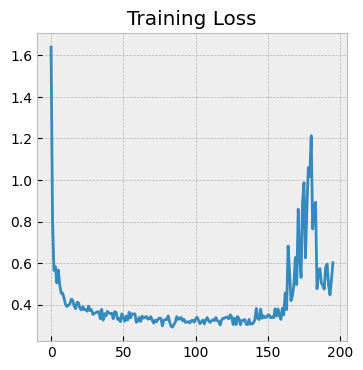

In [30]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss)
plt.title("Training Loss")
plt.show()